In [1]:
# basic
import os
import gc
import sys
import yaml
import warnings
import random
from pathlib import Path
from glob import glob
from tqdm import tqdm_notebook as tqdm
import hashlib
import pickle
warnings.filterwarnings('ignore')

# usual
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta

# preprocess
from fasttext import load_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
#import texthero as hero
import nltk
import collections
from gensim.models import word2vec, KeyedVectors
import cv2
import string
import re
import fasttext

# LightGBM
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb  # チューニング用

# visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas_profiling import ProfileReport  # profile report を作る用

# preprocessing
from sklearn.preprocessing import LabelEncoder

# plot settings
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams['font.family'] = 'sans_serif'
sns.set(style="whitegrid",  palette="muted", color_codes=True, rc={'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

# plot extentions
#import japanize_matplotlib
from matplotlib_venn import venn2

from tqdm import tqdm
tqdm.pandas()

In [2]:
# 試験ID生成
trial_prefix = 'nb021'  # ←手動で指定 
dttm_now = datetime.now().strftime('%Y%m%d_%H%M%S')
trial_id = f'{trial_prefix}_{dttm_now}'

print(trial_prefix)
print(trial_id)

nb021
nb021_20210602_225025


In [3]:
# アウトプットの出力先指定
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    OUTPUT_DIR = Path(".")
else:
    OUTPUT_DIR = Path(f"../03_outputs/{trial_prefix}")
    OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [4]:
# seed固定
def set_seed(seed=2021):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

SEED = 2021
set_seed(SEED)

In [5]:
# インプットフォルダ指定
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    DATA_DIR = '../input/commonlitreadabilityprize/'
else:
    DATA_DIR = '../00_input/commonlitreadabilityprize/'

In [6]:
# read_data
train_base = pd.read_csv(DATA_DIR + 'train.csv')
test_base = pd.read_csv(DATA_DIR + 'test.csv')
sample = pd.read_csv(DATA_DIR + 'sample_submission.csv')

## 特徴作成_共通処理

In [7]:
# ベースとなる継承元のクラス
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    def transform(self, input_df):
        raise NotImplementedError()

## テキスト特徴_共通処理

In [8]:
# ローカルの場合、stopwordsをダウンロード
import nltk
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    import nltk
    nltk.download('stopwords')
    nltk.download('averaged_perceptron_tagger')
    os.listdir(os.path.expanduser('~/nltk_data/corpora/stopwords/'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ktdogome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ktdogome/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [9]:
# テキスト前処理
# https://www.kaggle.com/alaasedeeq/commonlit-readability-eda

#filtering the unwanted symbols, spaces, ....etc
to_replace_by_space = re.compile('[/(){}\[\]|@,;]')
punctuation = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
bad_symbols = re.compile('[^0-9a-z #+_]')
stopwords = set(nltk.corpus.stopwords.words('english'))

def text_prepare(text):
    '''
    text: a string
    returna modified version of the string
    '''
    text = text.lower() # lowercase text
    text = re.sub(punctuation, '',text)
    text = re.sub(to_replace_by_space, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(bad_symbols, "", text)         # delete symbols which are in BAD_SYMBOLS_RE from text
    text = " ".join([word for word in text.split(" ") if word not in stopwords]) # delete stopwords from text
    text = re.sub(' +', ' ', text)
    return text


In [10]:
def text_normalization(s:pd.Series):
    x = s.apply(text_prepare)
    return x

# Counterオブジェクトを取得
def get_counter(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    counter = collections.Counter(text_list)
    return counter

## 前処理_品詞変換

In [11]:
# テキスト情報を品詞に変換
def get_pos_tag(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    pos_tag = [i[1] for i in nltk.pos_tag(text_list)]
    return pos_tag

def get_pos_tag_to_text(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    pos_tag = [i[1] for i in nltk.pos_tag(text_list)]
    return " ".join(pos_tag)

## テキスト特徴_シンプルなTF-IDF

In [12]:
# 参考: https://www.guruguru.science/competitions/16/discussions/556029f7-484d-40d4-ad6a-9d86337487e2/

class TfidfSimpleBlock(BaseBlock):
    """シンプルなTF-IDF特徴を作成する block"""
    def __init__(self, column: str, max_features=50, ngram_range=(1,1), use_idf=True):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.max_features=max_features
        self.ngram_range=ngram_range
        self.use_idf=use_idf

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, _master_df):
        """tdidfを計算するための全体集合を返す."""
        return _master_df

    def fit(self, 
            input_df, 
            _master_df=None, 
            y=None
           ):
        master_df = input_df if _master_df is None else self.get_master(_master_df)
        text = self.preprocess(master_df)
        self.vectorizer_ = TfidfVectorizer(max_features=self.max_features
                                      ,ngram_range=self.ngram_range
                                      ,use_idf=self.use_idf)

        self.vectorizer_.fit(text)
        self.prefix = 'tfidf' if self.use_idf == True else 'tf'
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.vectorizer_.transform(text)

        out_df = pd.DataFrame(z.toarray())
        out_df.columns = self.vectorizer_.get_feature_names()
        return out_df.add_prefix(f'{self.prefix}_')


## テキスト特徴_学習済みモデル（gemsim経由）

In [38]:
# 参考: https://zenn.dev/koukyo1994/articles/9b1da2482d8ba1
# 参考: https://github.com/yagays/swem

class GensimPreTrainedBlock(BaseBlock):
    """
    文書をgemsim経由で学習済みモデルのベクトル表現へ変換するblock
    モデルは別途入手し、インスタンス作成時に指定する。
    モデル名は手動で入力する想定（デフォルトではgensim_pretrained で入る）
    """
    def __init__(self,
                 column: str,
                 model:KeyedVectors,
                 model_name='gensim_pretrained',
                 swem='aver'):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.model = model
        self.model_name = model_name
        self.swem = swem # TODO:例外処理['aver', 'max', 'concat', 'hier']

    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        
        if self.swem == 'aver':
            feat = text.map(lambda x: self.average_pooling(x))
        elif self.swem == 'max': 
            feat = text.map(lambda x: self.max_pooling(x))
        elif self.swem == 'concat': 
            feat = text.map(lambda x: self.concat_average_max_pooling(x))
        elif self.swem == 'hier': 
            feat = text.map(lambda x: self.hierarchical_pooling(x, n=3))
            
        out_df = pd.DataFrame(np.stack(feat.values))

        return out_df.add_prefix(f'{self.model_name}_{self.column}_{self.swem}')
    
    # 前処理
    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x
    
    # 文書ベクトルの取得
    def get_sentence_vector(self, x: str):
        ndim = self.model.vector_size
        embeddings = [
            self.model[word]
            if word in self.model
            else np.zeros(ndim)
            for word in x.split()
        ]

        if len(embeddings) == 0:
            return np.zeros(ndim, dtype=np.float32)
        else:
            return embeddings
    
    # SWEMの各処理
    def average_pooling(self, text):
        word_embeddings = self.get_sentence_vector(text)
        return np.mean(word_embeddings, axis=0)

    def max_pooling(self, text):
        word_embeddings = self.get_sentence_vector(text)
        return np.max(word_embeddings, axis=0)

    def concat_average_max_pooling(self, text):
        word_embeddings = self.get_sentence_vector(text)
        return np.r_[np.mean(word_embeddings, axis=0), np.max(word_embeddings, axis=0)]

    def hierarchical_pooling(self, text, n):
        word_embeddings = self.get_sentence_vector(text)

        text_len = len(word_embeddings) # TODO: これで合ってるか要確認
        if n > text_len:
            raise ValueError(f"window size must be less than text length / window_size:{n} text_length:{text_len}")
        window_average_pooling_vec = [np.mean(word_embeddings[i:i + n], axis=0) for i in range(text_len - n + 1)]

        return np.max(window_average_pooling_vec, axis=0)    
            


In [33]:
# モデル入手
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    fast_path = '../input/fasttext-pretrained-crawl-vector-en-bin/cc.en.300.bin'
    gen_glv_wiki_path = '../input/stanfords-glove-pretrained-word-vectors/glove.6B.300d.txt'
    gen_glv_twi_path = '../input/glovetwitter27b-in-gensim-kv-format/glove.twitter.27B.200d.kv'
    gen_ggl_path = '../input/gensim-google-data/GoogleNews-vectors-negative300.bin'

    ft_model = fasttext.load_model(fast_path)
    gen_glv_wiki_model = KeyedVectors.load_word2vec_format(gen_glv_wiki_path, binary=False)
    #gen_glv_twi_model = KeyedVectors.load(gen_glv_twi_path)
    #gen_ggl_model = KeyedVectors.load_word2vec_format(gen_ggl_path, binary=True)
    
else: # ローカルまたは自前のクラウド環境を想定
    fast_path = '../97_pre_trained/cc.en.300.bin'
    gen_glv_wiki_path = '~/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300'
    gen_glv_twi_path = '~/gensim-data/glove-twitter-200/glove-twitter-200.gz'
    gen_ggl_path = '~/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz'

    ft_model = fasttext.load_model('../97_pre_trained/cc.en.300.bin')
    gen_glv_wiki_model = KeyedVectors.load_word2vec_format(gen_glv_wiki_path, binary=False)
    #gen_glv_twi_model = KeyedVectors.load_word2vec_format(gen_glv_twi_path, binary=False)
    #gen_ggl_model = KeyedVectors.load_word2vec_format(gen_ggl_path, binary=True)

In [34]:
gen_glv_wiki = GensimPreTrainedBlock('excerpt'
                                     ,gen_glv_wiki_model
                                     ,model_name='glove_wiki_giga300'
                                     ,swem='aver')
gen_glv_wiki.fit(train_base).head()

,glove_wiki_giga300_excerpt_aver0,glove_wiki_giga300_excerpt_aver1,glove_wiki_giga300_excerpt_aver2,glove_wiki_giga300_excerpt_aver3,glove_wiki_giga300_excerpt_aver4,glove_wiki_giga300_excerpt_aver5,glove_wiki_giga300_excerpt_aver6,glove_wiki_giga300_excerpt_aver7,glove_wiki_giga300_excerpt_aver8,glove_wiki_giga300_excerpt_aver9,...,glove_wiki_giga300_excerpt_aver290,glove_wiki_giga300_excerpt_aver291,glove_wiki_giga300_excerpt_aver292,glove_wiki_giga300_excerpt_aver293,glove_wiki_giga300_excerpt_aver294,glove_wiki_giga300_excerpt_aver295,glove_wiki_giga300_excerpt_aver296,glove_wiki_giga300_excerpt_aver297,glove_wiki_giga300_excerpt_aver298,glove_wiki_giga300_excerpt_aver299
0,-0.132493,0.068383,-0.048596,-0.161134,-0.101473,0.079182,-0.041147,0.010564,0.018888,-0.752718,...,-0.011532,-0.028315,-0.088636,0.131376,0.000332,-0.039241,0.114843,-0.064921,-0.013798,0.057710
1,-0.077150,-0.018101,-0.086769,-0.086145,0.007795,-0.039690,-0.015103,-0.042072,-0.017759,-0.787286,...,0.024324,-0.075369,0.120321,-0.053721,0.014178,-0.205254,0.009646,0.002112,-0.038091,0.176335
2,-0.066146,0.057035,-0.041531,0.012919,-0.061829,-0.003759,-0.046216,0.004215,-0.046633,-0.660977,...,0.069188,-0.012950,0.079883,0.081166,-0.057945,-0.090545,0.042625,-0.071038,0.030768,0.071548
3,-0.126935,-0.050144,0.009921,-0.140457,0.028346,0.072201,0.001486,0.045136,0.084098,-0.513308,...,0.117914,0.081417,0.056908,0.115584,0.088246,0.011493,-0.046504,-0.025073,0.045145,0.078601
4,-0.088530,-0.015162,-0.114838,-0.152095,0.121770,0.126901,0.077093,0.182776,0.143334,-0.963848,...,-0.072003,-0.061711,0.052746,-0.109673,-0.111921,0.000832,0.096237,0.069509,-0.081830,0.118160


In [35]:
gen_glv_wiki = GensimPreTrainedBlock('excerpt'
                                     ,gen_glv_wiki_model
                                     ,model_name='glove_wiki_giga300'
                                     ,swem='max')
gen_glv_wiki.fit(train_base).head()

,glove_wiki_giga300_excerpt_max0,glove_wiki_giga300_excerpt_max1,glove_wiki_giga300_excerpt_max2,glove_wiki_giga300_excerpt_max3,glove_wiki_giga300_excerpt_max4,glove_wiki_giga300_excerpt_max5,glove_wiki_giga300_excerpt_max6,glove_wiki_giga300_excerpt_max7,glove_wiki_giga300_excerpt_max8,glove_wiki_giga300_excerpt_max9,...,glove_wiki_giga300_excerpt_max290,glove_wiki_giga300_excerpt_max291,glove_wiki_giga300_excerpt_max292,glove_wiki_giga300_excerpt_max293,glove_wiki_giga300_excerpt_max294,glove_wiki_giga300_excerpt_max295,glove_wiki_giga300_excerpt_max296,glove_wiki_giga300_excerpt_max297,glove_wiki_giga300_excerpt_max298,glove_wiki_giga300_excerpt_max299
0,0.63926,1.02570,0.85222,0.53743,0.66141,0.91581,0.57508,1.12460,0.76950,0.77662,...,1.02740,0.78353,0.69672,1.14660,0.78563,1.03730,1.16630,0.90531,0.93160,0.70632
1,0.45156,0.50527,0.67024,0.90737,0.66623,0.90619,0.79681,0.96572,0.68705,0.80330,...,0.68377,0.64079,0.89830,0.56190,0.69525,0.63988,0.69387,0.81568,0.62037,1.08170
2,0.90503,1.08510,0.55868,0.95654,0.59524,1.24210,0.73086,1.12460,0.53200,1.40140,...,0.95765,0.56103,0.81452,0.87199,0.53413,0.93924,0.76899,0.55750,0.96150,0.87473
3,0.61591,0.70925,0.74003,0.52218,0.73232,1.26850,1.00810,0.87658,0.84728,0.90298,...,0.78052,0.62019,1.12090,0.73321,0.84934,0.94222,0.92246,0.60492,0.75641,0.85450
4,0.26288,0.65775,0.42134,0.46062,0.60808,0.43824,0.79705,0.96572,0.55073,0.47786,...,0.46728,0.78989,0.40725,0.48581,0.62087,0.81411,0.72788,0.58048,0.35338,1.02780


In [36]:
gen_glv_wiki = GensimPreTrainedBlock('excerpt'
                                     ,gen_glv_wiki_model
                                     ,model_name='glove_wiki_giga300'
                                     ,swem='concat')
gen_glv_wiki.fit(train_base).head()

,glove_wiki_giga300_excerpt_concat0,glove_wiki_giga300_excerpt_concat1,glove_wiki_giga300_excerpt_concat2,glove_wiki_giga300_excerpt_concat3,glove_wiki_giga300_excerpt_concat4,glove_wiki_giga300_excerpt_concat5,glove_wiki_giga300_excerpt_concat6,glove_wiki_giga300_excerpt_concat7,glove_wiki_giga300_excerpt_concat8,glove_wiki_giga300_excerpt_concat9,...,glove_wiki_giga300_excerpt_concat590,glove_wiki_giga300_excerpt_concat591,glove_wiki_giga300_excerpt_concat592,glove_wiki_giga300_excerpt_concat593,glove_wiki_giga300_excerpt_concat594,glove_wiki_giga300_excerpt_concat595,glove_wiki_giga300_excerpt_concat596,glove_wiki_giga300_excerpt_concat597,glove_wiki_giga300_excerpt_concat598,glove_wiki_giga300_excerpt_concat599
0,-0.132493,0.068383,-0.048596,-0.161134,-0.101473,0.079182,-0.041147,0.010564,0.018888,-0.752718,...,1.02740,0.78353,0.69672,1.14660,0.78563,1.03730,1.16630,0.90531,0.93160,0.70632
1,-0.077150,-0.018101,-0.086769,-0.086145,0.007795,-0.039690,-0.015103,-0.042072,-0.017759,-0.787286,...,0.68377,0.64079,0.89830,0.56190,0.69525,0.63988,0.69387,0.81568,0.62037,1.08170
2,-0.066146,0.057035,-0.041531,0.012919,-0.061829,-0.003759,-0.046216,0.004215,-0.046633,-0.660977,...,0.95765,0.56103,0.81452,0.87199,0.53413,0.93924,0.76899,0.55750,0.96150,0.87473
3,-0.126935,-0.050144,0.009921,-0.140457,0.028346,0.072201,0.001486,0.045136,0.084098,-0.513308,...,0.78052,0.62019,1.12090,0.73321,0.84934,0.94222,0.92246,0.60492,0.75641,0.85450
4,-0.088530,-0.015162,-0.114838,-0.152095,0.121770,0.126901,0.077093,0.182776,0.143334,-0.963848,...,0.46728,0.78989,0.40725,0.48581,0.62087,0.81411,0.72788,0.58048,0.35338,1.02780


In [39]:
gen_glv_wiki = GensimPreTrainedBlock('excerpt'
                                     ,gen_glv_wiki_model
                                     ,model_name='glove_wiki_giga300'
                                     ,swem='hier')
gen_glv_wiki.fit(train_base).head()

,glove_wiki_giga300_excerpt_hier0,glove_wiki_giga300_excerpt_hier1,glove_wiki_giga300_excerpt_hier2,glove_wiki_giga300_excerpt_hier3,glove_wiki_giga300_excerpt_hier4,glove_wiki_giga300_excerpt_hier5,glove_wiki_giga300_excerpt_hier6,glove_wiki_giga300_excerpt_hier7,glove_wiki_giga300_excerpt_hier8,glove_wiki_giga300_excerpt_hier9,...,glove_wiki_giga300_excerpt_hier290,glove_wiki_giga300_excerpt_hier291,glove_wiki_giga300_excerpt_hier292,glove_wiki_giga300_excerpt_hier293,glove_wiki_giga300_excerpt_hier294,glove_wiki_giga300_excerpt_hier295,glove_wiki_giga300_excerpt_hier296,glove_wiki_giga300_excerpt_hier297,glove_wiki_giga300_excerpt_hier298,glove_wiki_giga300_excerpt_hier299
0,0.274353,0.432596,0.362409,0.250670,0.250280,0.531933,0.335710,0.507390,0.438094,0.256387,...,0.458818,0.636893,0.264650,0.858433,0.371180,0.591063,0.754100,0.545527,0.589500,0.492780
1,0.288123,0.385770,0.478027,0.399013,0.283600,0.378376,0.662000,0.429660,0.295553,0.240486,...,0.553253,0.272642,0.645773,0.241098,0.397667,0.311227,0.363867,0.406249,0.318004,0.733973
2,0.392569,0.544685,0.376233,0.436075,0.332667,0.617663,0.399803,0.547473,0.287710,0.480113,...,0.622887,0.304997,0.463240,0.537480,0.307723,0.565290,0.361550,0.332817,0.409530,0.563837
3,0.374561,0.471473,0.586400,0.393373,0.436310,0.601307,0.486903,0.527050,0.561527,0.648783,...,0.489470,0.407393,0.915587,0.593097,0.651177,0.652137,0.272793,0.400677,0.486390,0.545593
4,0.242220,0.445373,0.054563,0.193834,0.478250,0.361007,0.447833,0.577667,0.410397,-0.193430,...,0.241700,0.155030,0.323080,0.462130,0.304313,0.467459,0.428453,0.440790,0.195234,0.622244


## テキスト特徴_fasttest

In [16]:
# 参考: https://zenn.dev/koukyo1994/articles/9b1da2482d8ba1
class FasttextBlock(BaseBlock):
    """文書をfasttextのテキスト表現へ変換する block"""
    def __init__(self, column: str, ft_model:fasttext.FastText._FastText):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.ft_model = ft_model

    # 前処理
    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x
        
    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        feat = text.map(lambda x: ft_model.get_sentence_vector(x))
        out_df = pd.DataFrame(np.stack(feat.values))

        return out_df.add_prefix(f'fasttext_{self.column}_')

## テキスト特徴_統計量

In [17]:
class TextDescriptionBlock(BaseBlock):
    """テキストに関する統計量を返す block"""
    def __init__(self, column: str):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column

    # 前処理
    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x
        
    def fit(self, input_df, y=None, n_components=50):
        self.text = self.preprocess(input_df)
        self.counters = self.text.map(get_counter)
        return self.transform(input_df)

    def transform(self, input_df):
        _length = input_df[self.column].fillna('').map(lambda x: len(x) if x!='' else np.nan)
        _wrd_cnt = self.counters.map(lambda x: sum(x.values()))
        _wrd_nuniq = self.counters.map(lambda x: len(x))
        _wrd_mean = self.counters.map(lambda x: np.mean(list(x.values())))
        _wrd_max = self.counters.map(lambda x: np.max(list(x.values())))
        
        word_length = self.counters.map(lambda x: np.array([len(i) for i in x.keys()]))
        word_length_desc = word_length.map(lambda x: pd.Series(x.ravel()).describe())
        _word_length_desc_df = pd.DataFrame(word_length_desc.tolist()).iloc[:,1:]
        _word_length_desc_df = _word_length_desc_df.add_prefix('word_length_')
        
        out_df = pd.concat([_length, _wrd_cnt, _wrd_nuniq, _wrd_mean, _wrd_max], axis=1)
        out_df.columns = ['text_length', 'word_count', 'word_nunique', 'word_appearance_mean', 'word_appearance_max']
        out_df = pd.concat([out_df, _word_length_desc_df], axis=1)
        return out_df.add_suffix(f'_{self.column}')

## テキスト特徴_CountVectorizer

In [18]:
class CountVectorizerBlock(BaseBlock):
    """CountVectorizer x SVD による圧縮を行なう block"""
    def __init__(self, column: str, n_components=50, ngram_range=(1,1)):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.n_components=n_components
        self.ngram_range=ngram_range

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, _master_df):
        """tdidfを計算するための全体集合を返す."""
        return _master_df

    def fit(self, 
            input_df, 
            _master_df=None, 
            y=None
           ):
        master_df = input_df if _master_df is None else self.get_master(_master_df)
        text = self.preprocess(master_df)
        self.pileline_ = Pipeline([
            ('tfidf', CountVectorizer(ngram_range=self.ngram_range)),
            ('svd', TruncatedSVD(n_components=self.n_components, random_state=SEED)),
        ])

        self.pileline_.fit(text)
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.pileline_.transform(text)

        out_df = pd.DataFrame(z)
        return out_df.add_prefix(f'countvect_{self.column}_{"_".join([str(i) for i in self.ngram_range])}_')


## テキスト特徴_TF-IDF

In [19]:
# 参考: https://www.guruguru.science/competitions/16/discussions/556029f7-484d-40d4-ad6a-9d86337487e2/

class TfidfBlock(BaseBlock):
    """tfidf x SVD による圧縮を行なう block"""
    def __init__(self, column: str, n_components=50, ngram_range=(1,1)):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.n_components=n_components
        self.ngram_range=ngram_range

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, _master_df):
        """tdidfを計算するための全体集合を返す."""
        return _master_df

    def fit(self, 
            input_df, 
            _master_df=None, 
            y=None
           ):
        master_df = input_df if _master_df is None else self.get_master(_master_df)
        text = self.preprocess(master_df)
        self.pileline_ = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=100000, ngram_range=self.ngram_range)),
            ('svd', TruncatedSVD(n_components=self.n_components, random_state=SEED)),
        ])

        self.pileline_.fit(text)
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.pileline_.transform(text)

        out_df = pd.DataFrame(z)
        return out_df.add_prefix(f'tfidf_{self.column}_{"_".join([str(i) for i in self.ngram_range])}_')


## テキスト特徴_W2V(データセットから学習)

In [20]:
# https://www.guruguru.science/competitions/16/discussions/2fafef06-5a26-4d33-b535-a94cc9549ac4/
# https://www.guruguru.science/competitions/16/discussions/4a6f5f84-8491-4324-ba69-dec49dc648cd/

def hashfxn(x):
    return int(hashlib.md5(str(x).encode()).hexdigest(), 16)

class W2VTrainBlock(BaseBlock):
    """Word2Vecを学習し、文書のベクトル表現を得るブロック。
       学習済みモデルを使うパターンは、別に作成するものとする。"""
    def __init__(self, 
                 column: str, 
                 model_size=50, 
                 min_count=1, 
                 window=5,
                 n_iter=100
                 ):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.model_size=model_size
        self.min_count=min_count
        self.window=window
        self.n_iter=n_iter

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, _master_df):
        """Word2Vecを学習するための全体集合を返す."""
        return _master_df

    def fit(self, 
            input_df, 
            _master_df=None
           ):
        master_df = input_df if _master_df is None else self.get_master(_master_df)
        text = self.preprocess(master_df)
        word_lists = text.map(lambda x: [i for i in x.split(' ') if i not in (' ')])
        self.w2v_model = word2vec.Word2Vec(word_lists.values.tolist(),
                                      vector_size=self.model_size,
                                      min_count=self.min_count,
                                      window=self.window,
                                      seed=SEED,
                                      workers=1,
                                      hashfxn=hashfxn,
                                      epochs=self.n_iter)

        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        word_lists = text.map(lambda x: [i for i in x.split(' ') if i not in (' ')])

        # 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって文章ベクトルにする
        sentence_vectors = word_lists.progress_apply(
            lambda x: np.mean([self.w2v_model.wv[e] for e in x], axis=0))
        sentence_vectors = np.vstack([x for x in sentence_vectors])
        sentence_vector_df = pd.DataFrame(sentence_vectors,
                                          columns=[f"w2v_{self.column}_w{self.window}_{i}"
                                                   for i in range(self.model_size)])
        
        return sentence_vector_df


# make_feat

In [106]:
# 初期化
train_feat = pd.DataFrame()
test_feat = pd.DataFrame()
train_target = train_base['target'].copy()

# tfidf作成用のdf作成
whole_df = pd.concat([train_base[['id', 'excerpt']], test_base[['id', 'excerpt']]], axis='rows')

In [107]:
# block初期化
gen_glv_wiki_aver = GensimPreTrainedBlock('excerpt'
                                     ,gen_glv_wiki_model
                                     ,model_name='glove_wiki_giga300'
                                     ,swem='aver')
gen_glv_wiki_max = GensimPreTrainedBlock('excerpt'
                                     ,gen_glv_wiki_model
                                     ,model_name='glove_wiki_giga300'
                                     ,swem='max')
gen_glv_wiki_con = GensimPreTrainedBlock('excerpt'
                                     ,gen_glv_wiki_model
                                     ,model_name='glove_wiki_giga300'
                                     ,swem='concat')
gen_glv_wiki_hier = GensimPreTrainedBlock('excerpt'
                                     ,gen_glv_wiki_model
                                     ,model_name='glove_wiki_giga300'
                                     ,swem='hier')

In [108]:
# fit & trainの特徴作成
train_feat = pd.concat([train_feat, gen_glv_wiki_aver.fit(train_base)], axis='columns')
#train_feat = pd.concat([train_feat, gen_glv_wiki_max.fit(train_base)], axis='columns')
#train_feat = pd.concat([train_feat, gen_glv_wiki_con.fit(train_base)], axis='columns')
#train_feat = pd.concat([train_feat, gen_glv_wiki_hier.fit(train_base)], axis='columns')

In [109]:
# testの特徴作成
test_feat = pd.concat([test_feat, gen_glv_wiki_aver.fit(test_base)], axis='columns')
#test_feat = pd.concat([test_feat, gen_glv_wiki_max.fit(test_base)], axis='columns')
#test_feat = pd.concat([test_feat, gen_glv_wiki_con.fit(test_base)], axis='columns')
#test_feat = pd.concat([test_feat, gen_glv_wiki_hier.fit(test_base)], axis='columns')

In [110]:
print(train_feat.shape)
train_feat.head()

(2834, 300)


,glove_wiki_giga300_excerpt_aver0,glove_wiki_giga300_excerpt_aver1,glove_wiki_giga300_excerpt_aver2,glove_wiki_giga300_excerpt_aver3,glove_wiki_giga300_excerpt_aver4,glove_wiki_giga300_excerpt_aver5,glove_wiki_giga300_excerpt_aver6,glove_wiki_giga300_excerpt_aver7,glove_wiki_giga300_excerpt_aver8,glove_wiki_giga300_excerpt_aver9,...,glove_wiki_giga300_excerpt_aver290,glove_wiki_giga300_excerpt_aver291,glove_wiki_giga300_excerpt_aver292,glove_wiki_giga300_excerpt_aver293,glove_wiki_giga300_excerpt_aver294,glove_wiki_giga300_excerpt_aver295,glove_wiki_giga300_excerpt_aver296,glove_wiki_giga300_excerpt_aver297,glove_wiki_giga300_excerpt_aver298,glove_wiki_giga300_excerpt_aver299
0,-0.132493,0.068383,-0.048596,-0.161134,-0.101473,0.079182,-0.041147,0.010564,0.018888,-0.752718,...,-0.011532,-0.028315,-0.088636,0.131376,0.000332,-0.039241,0.114843,-0.064921,-0.013798,0.057710
1,-0.077150,-0.018101,-0.086769,-0.086145,0.007795,-0.039690,-0.015103,-0.042072,-0.017759,-0.787286,...,0.024324,-0.075369,0.120321,-0.053721,0.014178,-0.205254,0.009646,0.002112,-0.038091,0.176335
2,-0.066146,0.057035,-0.041531,0.012919,-0.061829,-0.003759,-0.046216,0.004215,-0.046633,-0.660977,...,0.069188,-0.012950,0.079883,0.081166,-0.057945,-0.090545,0.042625,-0.071038,0.030768,0.071548
3,-0.126935,-0.050144,0.009921,-0.140457,0.028346,0.072201,0.001486,0.045136,0.084098,-0.513308,...,0.117914,0.081417,0.056908,0.115584,0.088246,0.011493,-0.046504,-0.025073,0.045145,0.078601
4,-0.088530,-0.015162,-0.114838,-0.152095,0.121770,0.126901,0.077093,0.182776,0.143334,-0.963848,...,-0.072003,-0.061711,0.052746,-0.109673,-0.111921,0.000832,0.096237,0.069509,-0.081830,0.118160


In [111]:
print(test_feat.shape)
test_feat.head()

(7, 300)


,glove_wiki_giga300_excerpt_aver0,glove_wiki_giga300_excerpt_aver1,glove_wiki_giga300_excerpt_aver2,glove_wiki_giga300_excerpt_aver3,glove_wiki_giga300_excerpt_aver4,glove_wiki_giga300_excerpt_aver5,glove_wiki_giga300_excerpt_aver6,glove_wiki_giga300_excerpt_aver7,glove_wiki_giga300_excerpt_aver8,glove_wiki_giga300_excerpt_aver9,...,glove_wiki_giga300_excerpt_aver290,glove_wiki_giga300_excerpt_aver291,glove_wiki_giga300_excerpt_aver292,glove_wiki_giga300_excerpt_aver293,glove_wiki_giga300_excerpt_aver294,glove_wiki_giga300_excerpt_aver295,glove_wiki_giga300_excerpt_aver296,glove_wiki_giga300_excerpt_aver297,glove_wiki_giga300_excerpt_aver298,glove_wiki_giga300_excerpt_aver299
0,-0.078179,-0.073587,-0.035312,-0.099673,-0.049428,-0.043395,0.017952,0.095954,0.043515,-1.248539,...,-0.060878,-0.023364,0.007092,-0.043388,0.070862,0.048235,-0.025931,-0.069404,-0.036398,0.139124
1,-0.120849,0.108297,-0.061911,-0.038419,0.052452,-0.036205,0.069263,0.010547,0.004923,-0.998682,...,-0.025669,0.015288,0.060223,0.065259,0.076804,-0.201838,0.075769,-0.137990,-0.126795,0.204014
2,-0.168833,-0.021294,0.025423,-0.128907,-0.046154,0.008616,-0.089749,-0.083027,-0.001132,-0.637801,...,0.056460,0.026227,0.056739,-0.051877,-0.053584,-0.108842,0.140410,-0.021539,-0.060603,0.189821
3,-0.233050,0.207927,-0.140284,-0.187197,-0.082320,0.138931,-0.034752,-0.035099,0.194923,-1.146375,...,-0.041697,-0.202587,-0.068731,-0.030486,0.133103,0.323549,0.172144,-0.287680,0.102706,-0.102187
4,-0.069997,0.028082,0.099395,-0.183581,0.018904,-0.038261,0.014868,0.044082,0.103041,-1.229965,...,0.011584,-0.107653,-0.065497,0.124859,0.030388,0.140741,-0.075218,-0.130022,-0.039952,-0.082639


In [112]:
print(train_feat.shape)
print(test_feat.shape)

(2834, 300)
(7, 300)


# train & predict

In [113]:
from sklearn.model_selection import KFold

def kfold_cv(X, y, n_splits=5, random_state=0):
    folds = KFold(n_splits=n_splits, random_state=0, shuffle=True)
    return list(folds.split(X, y))

In [114]:
target = 'target'
cv = kfold_cv(train_feat, train_target)

In [115]:
params = {
    'objective': 'regression',
    'metrics': 'rmse',
    'seed': SEED
}

In [116]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [117]:
oof_preds = np.zeros(len(train_feat))
test_preds = np.zeros(len(test_feat))

importances = pd.DataFrame()
scores = []
models = []

for i, (train_index, valid_index) in enumerate(cv):
    print(f'\nFold {i + 1}')
    trn_x, trn_y = train_feat.iloc[train_index], train_target.iloc[train_index]
    val_x, val_y = train_feat.iloc[valid_index], train_target.iloc[valid_index]
    
    #dtrain = lgb.Dataset(trn_x, trn_y, categorical_feature = ['LE_' + val_ for val_ in le_categories])
    #dvalid = lgb.Dataset(val_x, val_y, categorical_feature = ['LE_' + val_ for val_ in le_categories])

    dtrain = lgb.Dataset(trn_x, trn_y)
    dvalid = lgb.Dataset(val_x, val_y)

    model = lgb.train(
        params,
        train_set=dtrain,
        num_boost_round=100000,
        valid_sets=[dtrain, dvalid],
        valid_names=['training', 'valid'],
        early_stopping_rounds=20,
        verbose_eval=50
    )
    
    val_preds = model.predict(val_x)
    oof_preds[valid_index] = val_preds
    test_preds += model.predict(test_feat) / 5
    
    val_score = model.best_score['valid']['rmse']
    scores.append(val_score)
    models.append(model)
    
    imp_df = pd.DataFrame({
        'feature': model.feature_name(),
        'gain': model.feature_importance(importance_type='gain'),
        'fold': i+1
    })
    
    importances = pd.concat([importances, imp_df], axis=0)
    
mean_score = np.mean(scores)
std_score  = np.std(scores)
all_score  = np.sqrt(mean_squared_error(train_target, oof_preds))
metrics_name = 'RMSE'
print(f'Mean {metrics_name}: {mean_score}, std: {std_score}, All {metrics_name}: {all_score}')


Fold 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2267, number of used features: 300
[LightGBM] [Info] Start training from score -0.961023
Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.293338	valid's rmse: 0.682408
Early stopping, best iteration is:
[71]	training's rmse: 0.211412	valid's rmse: 0.676592

Fold 2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 2267, number of used features: 300
[LightGBM] [Info] Start training from score -0.946950
Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.2

In [118]:
sample['target'] = test_preds

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    sample.to_csv('submission.csv',index=False)
else:
    sample.to_csv(OUTPUT_DIR/'submission.csv',index=False)

In [119]:
print(sample.shape)
sample.head()

(7, 2)


,id,target
0,c0f722661,-1.195978
1,f0953f0a5,-0.428722
2,0df072751,-0.768122
3,04caf4e0c,-1.661301
4,0e63f8bea,-1.777867


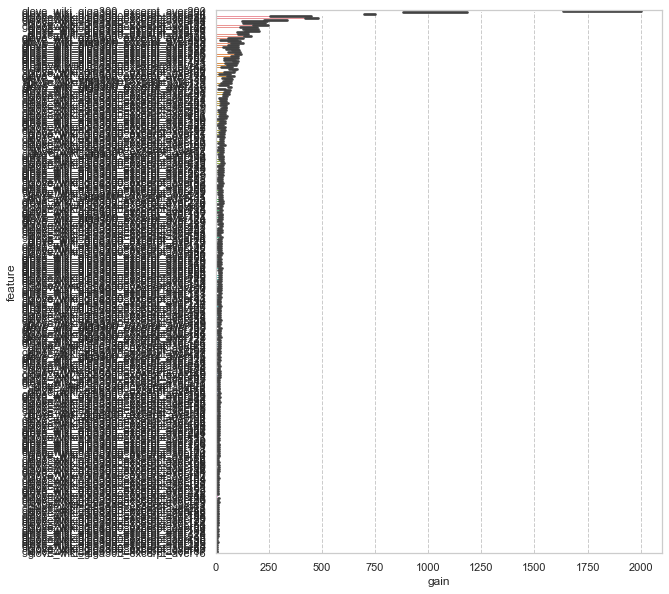

In [120]:
# importance(kaggle環境では描画しない)
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    plt.figure(figsize=(8, 10))
    sns.barplot(x='gain', y='feature', data=importances.sort_values('gain', ascending=False));
    plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importance.png'))

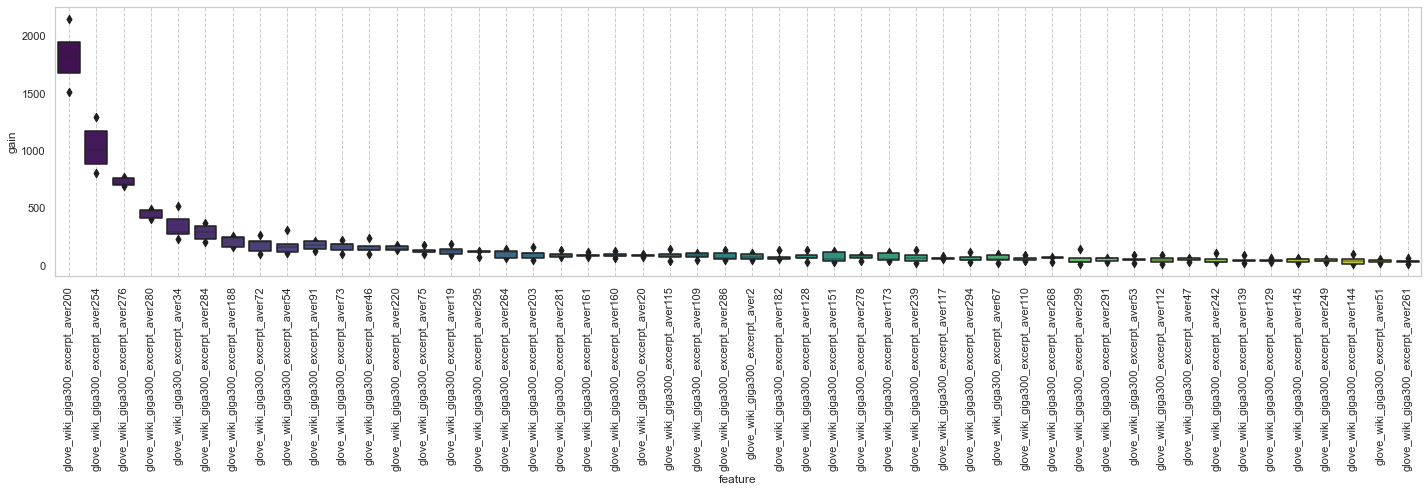

In [121]:
# importance_boxen(kaggle環境では描画しない)
# 参考: https://www.guruguru.science/competitions/13/discussions/d8f2d66a-aeee-4789-8b3d-d5935c26b1b7/

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    order = importances.groupby('feature')\
        .sum()[['gain']]\
        .sort_values('gain', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=importances, x='feature', y='gain', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    fig.savefig(os.path.join(OUTPUT_DIR, 'feature_importance_boxen.png'))

In [122]:
# SHAP(kaggle環境では描画しない)
# 参考その1: https://github.com/slundberg/shap/issues/337
# 参考その2: https://github.com/slundberg/shap/issues/630
import shap

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    shap_values = []
    for model_ in models:
        explainer = shap.TreeExplainer(model_)
        shap_values.append(explainer.shap_values(train_feat))

    shap_mean = np.mean(shap_values, axis=0)

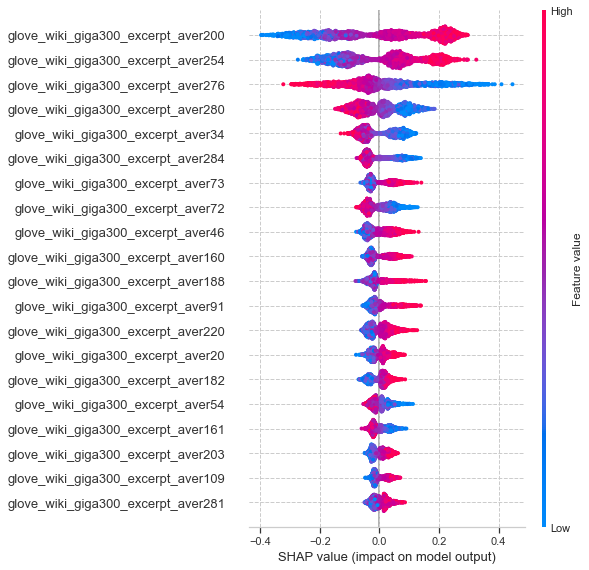

In [123]:
# SHAP_summary_plot
# 参考_画像の出力について: https://github.com/slundberg/shap/issues/153
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    shap.summary_plot(shap_mean, train_feat, show=False)
    plt.subplots_adjust(left=0.4, right=1.0)  # 保存画像のラベルが欠けるのを防ぐ
    plt.savefig(os.path.join(OUTPUT_DIR, 'shap_summary_plot.png'))

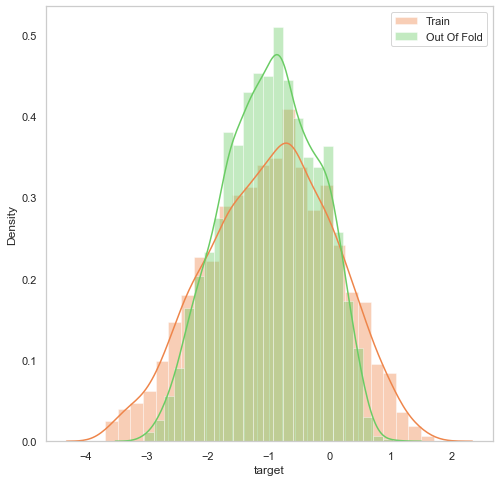

In [124]:
# 分布(train_vs_oof)
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.distplot(train_target, label='Train', ax=ax, color='C1')
    sns.distplot(oof_preds, label='Out Of Fold', ax=ax, color='C2')
    ax.legend()
    ax.grid()
    plt.savefig(os.path.join(OUTPUT_DIR, 'train_vs_oof.png'))